<a href="https://colab.research.google.com/github/sm-mehedi/Python-Google-Collab-/blob/main/Target_chest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
# ----------------------------
# 1️⃣ Install packages
# ----------------------------
!pip install --upgrade kaggle kagglehub --quiet

# ----------------------------
# 2️⃣ Set Kaggle API token
# ----------------------------
import os
os.environ['KAGGLE_API_TOKEN'] = 'KGAT_7e9d5062218308c031b1fa2f4b39a184'  # Replace with your token

# ----------------------------
# 3️⃣ Download dataset via kagglehub
# ----------------------------
import kagglehub

print("Downloading Chest CT-Scan Images dataset...")
dataset_path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")
print("Downloaded to:", dataset_path)

# ----------------------------
# 4️⃣ Move to /content/Data
# ----------------------------
!mkdir -p /content/Data
!mv $dataset_path/* /content/Data

# ----------------------------
# 5️⃣ Verify folder structure
# ----------------------------
print("\nFolder structure in /content/Data:")
!ls /content/Data
print("\nTrain folder contents:")
!ls /content/Data/train
print("\nTest folder contents:")
!ls /content/Data/test
print("\nValidation folder contents:")
!ls /content/Data/valid

print("\n✅ Dataset is ready! Use data_dir = '/content/Data' in your PyTorch code.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.4/192.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.8/269.8 kB 27.2 MB/s eta 0:00:00
Using Colab cache for faster access to the 'chest-ctscan-images' dataset.
Downloaded to: /kaggle/input/chest-ctscan-images
mv: cannot remove '/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (2).png': Read-only file system
mv: cannot 

In [ ]:
!mv /content/Data/Data/* /content/Data/
!rm -r /content/Data/Data


CNN+SVM Hybrid

Ensemble CNN+SVM

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Data transforms
# ---------------------------
tfm_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

tfm_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ---------------------------
# Dataset & DataLoader
# ---------------------------
data_dir = "/content/Data"
train_dataset = datasets.ImageFolder(f"{data_dir}/train", transform=tfm_train)
test_dataset  = datasets.ImageFolder(f"{data_dir}/test", transform=tfm_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

# ---------------------------
# CNN feature extractors (Transfer Learning)
# ---------------------------
def get_resnet18():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for p in model.parameters():
        p.requires_grad = False
    model.fc = nn.Identity()  # remove classifier
    return model.to(device)

def get_efficientnet():
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    for p in model.parameters():
        p.requires_grad = False
    model.classifier[1] = nn.Identity()  # remove classifier
    return model.to(device)

resnet18 = get_resnet18()
efficientnet = get_efficientnet()

# ---------------------------
# Feature extraction function
# ---------------------------
def extract_features(loader, nets):
    features, labels = [], []
    for x, y in loader:
        x = x.to(device)
        feats = []
        for net in nets:
            net.eval()
            with torch.no_grad():
                f = net(x)
            feats.append(f.cpu().numpy())
        feats = np.concatenate(feats, axis=1)
        features.append(feats)
        labels.append(y.numpy())
    return np.vstack(features), np.hstack(labels)

# ---------------------------
# Extract train features (ResNet18 + EfficientNet)
# ---------------------------
train_features, train_labels = extract_features(train_loader, [resnet18, efficientnet])

# Standardize + PCA
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

pca = PCA(n_components=200)
train_features_pca = pca.fit_transform(train_features_scaled)

# ---------------------------
# 5-Fold CV (Multi-CNN + PCA + SVM)
# ---------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recalls, f1s = [], [], [], []

for train_idx, val_idx in kf.split(train_features_pca, train_labels):
    X_tr, X_val = train_features_pca[train_idx], train_features_pca[val_idx]
    y_tr, y_val = train_labels[train_idx], train_labels[val_idx]

    svm = SVC(kernel='rbf', C=10, gamma='scale')
    svm.fit(X_tr, y_tr)
    y_pred = svm.predict(X_val)

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred, average='macro'))
    recalls.append(recall_score(y_val, y_pred, average='macro'))
    f1s.append(f1_score(y_val, y_pred, average='macro'))

print("\n=== 5-Fold CV Results (Multi-CNN + PCA + SVM) ===")
print(f"Accuracy : {np.mean(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f}")
print(f"Recall   : {np.mean(recalls):.4f}")
print(f"F1-score : {np.mean(f1s):.4f}")

# ---------------------------
# Test set evaluation
# ---------------------------
test_features, test_labels = extract_features(test_loader, [resnet18, efficientnet])
test_features_scaled = scaler.transform(test_features)
test_features_pca = pca.transform(test_features_scaled)

svm_final = SVC(kernel='rbf', C=10, gamma='scale')
svm_final.fit(train_features_pca, train_labels)
y_pred_test = svm_final.predict(test_features_pca)

acc_test = accuracy_score(test_labels, y_pred_test)
prec_test = precision_score(test_labels, y_pred_test, average='macro')
rec_test = recall_score(test_labels, y_pred_test, average='macro')
f1_test = f1_score(test_labels, y_pred_test, average='macro')

print("\n=== Test Set Results ===")
print(f"Accuracy : {acc_test:.4f}")
print(f"Precision: {prec_test:.4f}")
print(f"Recall   : {rec_test:.4f}")
print(f"F1-score : {f1_test:.4f}")

# Print class distribution
print("\nClass distribution in training set:", Counter([label for _, label in train_dataset]))


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Train samples: 613
Test samples: 315

=== 5-Fold CV Results (Multi-CNN + PCA + SVM) ===
Accuracy : 0.9070
Precision: 0.9248
Recall   : 0.8998
F1-score : 0.9071

=== Test Set Results ===
Accuracy : 0.8317
Precision: 0.8718
Recall   : 0.8331
F1-score : 0.8465

Class distribution in training set: Counter({0: 195, 3: 155, 2: 148, 1: 115})


CNN–PCA–SVM Hybrid Model

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

# -----------------------------
# Device
# -----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -----------------------------
# Paths
# -----------------------------
data_dir = "/content/Data"
train_dir = f"{data_dir}/train"
test_dir  = f"{data_dir}/test"

# -----------------------------
# Transforms
# -----------------------------
tfm_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

tfm_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# -----------------------------
# Load datasets
# -----------------------------
train_dataset = datasets.ImageFolder(train_dir, transform=tfm_train)
test_dataset  = datasets.ImageFolder(test_dir, transform=tfm_val)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Class distribution in train set:", Counter([y for _,y in train_dataset]))

# -----------------------------
# Pretrained Multi-CNN
# -----------------------------
def get_resnet18():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for p in model.parameters():
        p.requires_grad = False
    model.fc = nn.Identity()  # feature extractor
    return model.to(device)

def get_efficientnet():
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    for p in model.parameters():
        p.requires_grad = False
    model.classifier[1] = nn.Identity()  # feature extractor
    return model.to(device)

resnet18 = get_resnet18()
efficientnet = get_efficientnet()

# -----------------------------
# Feature extraction
# -----------------------------
def extract_features(loader, nets):
    features, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            feats = []
            for net in nets:
                net.eval()
                f = net(x)
                feats.append(f.cpu().numpy())
            feats = np.concatenate(feats, axis=1)
            features.append(feats)
            labels.append(y.numpy())
    return np.vstack(features), np.hstack(labels)

# -----------------------------
# 5-Fold CV on training set
# -----------------------------
labels = np.array([y for _, y in train_dataset])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, precs, recalls, f1s = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels), 1):
    print(f"\n--- Fold {fold} ---")

    from torch.utils.data import Subset
    train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=16, shuffle=True)
    val_loader   = DataLoader(Subset(train_dataset, val_idx), batch_size=16, shuffle=False)

    # Feature extraction
    X_train, y_train = extract_features(train_loader, [resnet18, efficientnet])
    X_val, y_val     = extract_features(val_loader, [resnet18, efficientnet])

    # Standardize + PCA
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)

    pca = PCA(n_components=200)
    X_train = pca.fit_transform(X_train)
    X_val   = pca.transform(X_val)

    # SVM
    svm = SVC(kernel='rbf', C=10, gamma='scale')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred, average='macro'))
    recalls.append(recall_score(y_val, y_pred, average='macro'))
    f1s.append(f1_score(y_val, y_pred, average='macro'))

    print(f"Accuracy : {accs[-1]:.4f}, Precision: {precs[-1]:.4f}, Recall: {recalls[-1]:.4f}, F1: {f1s[-1]:.4f}")

print("\n=== 5-Fold CV Results ===")
print(f"Mean Accuracy : {np.mean(accs):.4f}")
print(f"Mean Precision: {np.mean(precs):.4f}")
print(f"Mean Recall   : {np.mean(recalls):.4f}")
print(f"Mean F1-score : {np.mean(f1s):.4f}")

# -----------------------------
# Test set evaluation
# -----------------------------
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
X_train_full, y_train_full = extract_features(DataLoader(train_dataset, batch_size=16), [resnet18, efficientnet])
X_test, y_test = extract_features(test_loader, [resnet18, efficientnet])

scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

pca = PCA(n_components=200)
X_train_full = pca.fit_transform(X_train_full)
X_test = pca.transform(X_test)

svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train_full, y_train_full)
y_pred_test = svm.predict(X_test)

acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, average='macro')
rec_test = recall_score(y_test, y_pred_test, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')

print("\n=== Test Set Results ===")
print(f"Accuracy : {acc_test:.4f}, Precision: {prec_test:.4f}, Recall: {rec_test:.4f}, F1: {f1_test:.4f}")


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Train samples: 613
Test samples: 315
Class distribution in train set: Counter({0: 195, 3: 155, 2: 148, 1: 115})

--- Fold 1 ---
Accuracy : 0.8699, Precision: 0.8935, Recall: 0.8642, F1: 0.8684

--- Fold 2 ---
Accuracy : 0.8293, Precision: 0.8377, Recall: 0.8254, F1: 0.8294

--- Fold 3 ---
Accuracy : 0.8618, Precision: 0.8628, Recall: 0.8677, F1: 0.8649

--- Fold 4 ---
Accuracy : 0.8197, Precision: 0.8374, Recall: 0.8073, F1: 0.8160

--- Fold 5 ---
Accuracy : 0.8607, Precision: 0.8638, Recall: 0.8677, F1: 0.8655

=== 5-Fold CV Results ===
Mean Accuracy : 0.8483
Mean Precision: 0.8590
Mean Recall   : 0.8465
Mean F1-score : 0.8488

=== Test Set Results ===
Accuracy : 0.7333, Precision: 0.8071, Recall: 0.7450, F1: 0.7477


5-Fold CV SVM

CNN + SVM Hybrid update

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

# -----------------------------
# Device
# -----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -----------------------------
# Paths
# -----------------------------
data_dir = "/content/Data"
train_dir = f"{data_dir}/train"
test_dir  = f"{data_dir}/test"

# -----------------------------
# Transforms
# -----------------------------
tfm_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

tfm_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# -----------------------------
# Load datasets
# -----------------------------
train_dataset = datasets.ImageFolder(train_dir, transform=tfm_train)
test_dataset  = datasets.ImageFolder(test_dir, transform=tfm_val)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Class distribution in train set:", Counter([y for _,y in train_dataset]))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

# -----------------------------
# Pretrained CNN (ResNet18)
# -----------------------------
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze everything except layer4 and fc
for name, param in resnet18.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

# Save original in_features for fine-tuning
num_features = resnet18.fc.in_features

# Replace fc for fine-tuning
resnet18.fc = nn.Linear(num_features, len(train_dataset.classes))
resnet18 = resnet18.to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# -----------------------------
# CNN Fine-tuning
# -----------------------------
epochs = 3
for epoch in range(epochs):
    resnet18.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(resnet18(x), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

# -----------------------------
# Feature extraction
# -----------------------------
# Replace fc with Identity for feature extraction
resnet18.fc = nn.Identity()

def extract_features(loader):
    features, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            feats = resnet18(x)
            features.append(feats.cpu().numpy())
            labels.append(y.numpy())
    return np.concatenate(features), np.concatenate(labels)

X_train, y_train = extract_features(train_loader)
X_test, y_test   = extract_features(test_loader)

# -----------------------------
# Standardize + PCA
# -----------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

pca = PCA(n_components=200)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)

# -----------------------------
# 5-Fold CV SVM
# -----------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recalls, f1s = [], [], [], []

for train_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    svm = SVC(kernel='rbf', C=10, gamma='scale')
    svm.fit(X_tr, y_tr)
    y_pred = svm.predict(X_val)

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred, average='macro'))
    recalls.append(recall_score(y_val, y_pred, average='macro'))
    f1s.append(f1_score(y_val, y_pred, average='macro'))

print("\n=== 5-Fold CV SVM Metrics ===")
print(f"Accuracy : {np.mean(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f}")
print(f"Recall   : {np.mean(recalls):.4f}")
print(f"F1-score : {np.mean(f1s):.4f}")

# -----------------------------
# CNN + SVM Hybrid Test
# -----------------------------
svm_final = SVC(kernel='rbf', C=10, gamma='scale')
svm_final.fit(X_train, y_train)
y_pred_test = svm_final.predict(X_test)

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, average='macro')
rec  = recall_score(y_test, y_pred_test, average='macro')
f1   = f1_score(y_test, y_pred_test, average='macro')

print("\n=== CNN + SVM Hybrid Test Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# -----------------------------
# Final Results Table
# -----------------------------
print("\nModel\t\t\tAccuracy\tPrecision\tRecall\tF1-Score")
print(f"5-Fold CV SVM\t\t{np.mean(accs):.4f}\t{np.mean(precs):.4f}\t{np.mean(recalls):.4f}\t{np.mean(f1s):.4f}")
print(f"CNN + SVM Hybrid\t{acc:.4f}\t{prec:.4f}\t{rec:.4f}\t{f1:.4f}")


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Train samples: 613
Test samples: 315
Class distribution in train set: Counter({0: 195, 3: 155, 2: 148, 1: 115})
Epoch 1 Loss: 0.8945
Epoch 2 Loss: 0.4559
Epoch 3 Loss: 0.2789

=== 5-Fold CV SVM Metrics ===
Accuracy : 0.9576
Precision: 0.9595
Recall   : 0.9572
F1-score : 0.9580

=== CNN + SVM Hybrid Test Metrics ===
Accuracy : 0.3492
Precision: 0.3377
Recall   : 0.3131
F1-score : 0.3195

Model			Accuracy	Precision	Recall	F1-Score
5-Fold CV SVM		0.9576	0.9595	0.9572	0.9580
CNN + SVM Hybrid	0.3492	0.3377	0.3131	0.3195


CNN (ResNet18)

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Paths
# -----------------------------
data_dir = "/content/Data"
train_dir = f"{data_dir}/train"
test_dir  = f"{data_dir}/test"

# -----------------------------
# Transforms
# -----------------------------
tfm_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

tfm_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# -----------------------------
# Datasets and loaders
# -----------------------------
train_dataset = datasets.ImageFolder(train_dir, transform=tfm_train)
test_dataset  = datasets.ImageFolder(test_dir, transform=tfm_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Class distribution in train set:", Counter([y for _,y in train_dataset]))

# -----------------------------
# ResNet18 model
# -----------------------------
net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for name, param in net.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

num_features = net.fc.in_features
net.fc = nn.Linear(num_features, len(train_dataset.classes))
net = net.to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# -----------------------------
# Training
# -----------------------------
epochs = 5
for epoch in range(epochs):
    net.train()
    running_loss = 0
    for x,y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(net(x), y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"CNN Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")

# -----------------------------
# Evaluation on test set
# -----------------------------
all_preds, all_labels = [], []

net.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = net(x)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("\n=== Model Performance Summary ===")
print(f"{'Model':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print(f"{'CNN (ResNet18)':<15} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f}")


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Train samples: 613
Test samples: 315
Class distribution in train set: Counter({0: 195, 3: 155, 2: 148, 1: 115})
CNN Epoch 1 Loss: 0.7526
CNN Epoch 2 Loss: 0.2258
CNN Epoch 3 Loss: 0.0989
CNN Epoch 4 Loss: 0.0659
CNN Epoch 5 Loss: 0.0381

=== Model Performance Summary ===
Model           Accuracy   Precision  Recall     F1-Score  
CNN (ResNet18)  0.9079     0.9064     0.9329     0.9140    


SVM

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from collections import Counter

# ----------------------------
# Paths & transforms
# ----------------------------
data_dir = "/content/Data"  # updated path

tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(f"{data_dir}/train", tfm)
test_dataset  = datasets.ImageFolder(f"{data_dir}/test", tfm)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Class distribution in train set:", Counter([y for _, y in train_dataset]))

# ----------------------------
# Flatten images and collect labels
# ----------------------------
def extract_features(loader):
    features, labels = [], []
    for x, y in loader:
        features.append(x.view(x.size(0), -1).numpy())
        labels.append(y.numpy())
    return np.concatenate(features), np.concatenate(labels)

X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(test_loader)

# ----------------------------
# Standardize + PCA
# ----------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=200)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# ----------------------------
# SVM classifier
# ----------------------------
svm = SVC(kernel='rbf', C=10, gamma='scale')

# 5-Fold CV
cv_scores = cross_val_score(svm, X_train, y_train, cv=5)
cv_acc = np.mean(cv_scores)

# Train on full train set
svm.fit(X_train, y_train)

# Predictions on test set
y_pred = svm.predict(X_test)

# ----------------------------
# Metrics
# ----------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# ----------------------------
# Print table
# ----------------------------
print("\n=== Model Performance Summary ===")
print(f"{'Model':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print(f"{'SVM':<15} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f}")
print(f"{'5-Fold CV Acc':<15} {cv_acc:<10.4f}")


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Train samples: 613
Test samples: 315
Class distribution in train set: Counter({0: 195, 3: 155, 2: 148, 1: 115})

=== Model Performance Summary ===
Model           Accuracy   Precision  Recall     F1-Score  
SVM             0.5746     0.6598     0.6404     0.5939    
5-Fold CV Acc   0.8415    


RNN

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/content/Data"  # updated dataset path

# ----------------------------
# Data transforms
# ----------------------------
tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(f"{data_dir}/train", tfm)
test_dataset  = datasets.ImageFolder(f"{data_dir}/test", tfm)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Class distribution in train set:", Counter([y for _, y in train_dataset]))

# ----------------------------
# RNN model
# ----------------------------
class ImageRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        x = x.permute(0,2,3,1)          # B,H,W,C
        x = x.reshape(x.size(0), x.size(1), -1)  # B,H,W*C
        out,_ = self.rnn(x)
        out = self.fc(out[:,-1,:])
        return out

model = ImageRNN(input_size=224*3, hidden_size=128, num_layers=1, num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# ----------------------------
# Train
# ----------------------------
epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"RNN Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Evaluate
# ----------------------------
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

# ----------------------------
# Print summary table
# ----------------------------
print("\n=== Model Performance Summary ===")
print(f"{'Model':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print(f"{'RNN':<15} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f}")


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Train samples: 613
Test samples: 315
Class distribution in train set: Counter({0: 195, 3: 155, 2: 148, 1: 115})
RNN Epoch 1 Loss: 1.3412
RNN Epoch 2 Loss: 1.2715
RNN Epoch 3 Loss: 1.1846

=== Model Performance Summary ===
Model           Accuracy   Precision  Recall     F1-Score  
RNN             0.3524     0.3594     0.3414     0.2669    


Multi-CNN + PCA + SVM (5-Fold CV)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Deterministic transform for feature extraction (no random augmentation)
# ----------------------------
tfm_feat = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

data_dir = "/content/Data"  # updated dataset path
base_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=tfm_feat)

# Labels
all_labels = np.array([y for _, y in base_dataset.samples])
print("Classes:", base_dataset.classes)
print("Train samples:", len(base_dataset))
print("Class distribution:", Counter(all_labels))

# ----------------------------
# Pretrained CNNs (frozen feature extractors)
# ----------------------------
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)
efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)

# Remove classifiers
resnet18.fc = nn.Identity()
efficientnet.classifier[1] = nn.Identity()

# Freeze weights
resnet18.eval()
efficientnet.eval()
for p in resnet18.parameters(): p.requires_grad = False
for p in efficientnet.parameters(): p.requires_grad = False

@torch.no_grad()
def extract_features_from_subset(subset):
    loader = DataLoader(subset, batch_size=16, shuffle=False)
    feats_list, labels_list = [], []
    for x, y in loader:
        x = x.to(device)
        feats_res = resnet18(x)
        feats_eff = efficientnet(x)
        feats = torch.cat([feats_res, feats_eff], dim=1)
        feats_list.append(feats.cpu().numpy())
        labels_list.append(y.numpy())
    return np.concatenate(feats_list), np.concatenate(labels_list)

# ----------------------------
# Leakage-free 5-fold CV
# ----------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, precs, recalls, f1s = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(all_labels)), all_labels), 1):
    train_subset = Subset(base_dataset, train_idx)
    val_subset   = Subset(base_dataset, val_idx)

    # Extract features per fold
    X_tr, y_tr = extract_features_from_subset(train_subset)
    X_val, y_val = extract_features_from_subset(val_subset)

    # Standardize + PCA
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_val_s = scaler.transform(X_val)

    pca = PCA(n_components=200)
    X_tr_p = pca.fit_transform(X_tr_s)
    X_val_p = pca.transform(X_val_s)

    # Train SVM
    svm = SVC(kernel='rbf', C=10, gamma='scale')
    svm.fit(X_tr_p, y_tr)
    y_pred = svm.predict(X_val_p)

    accs.append(accuracy_score(y_val, y_pred))
    precs.append(precision_score(y_val, y_pred, average='macro', zero_division=0))
    recalls.append(recall_score(y_val, y_pred, average='macro', zero_division=0))
    f1s.append(f1_score(y_val, y_pred, average='macro', zero_division=0))

    print(f"Fold {fold}: Acc={accs[-1]:.4f}, F1={f1s[-1]:.4f}")

print("\n=== Leakage-Free 5-Fold CV Results (Multi-CNN frozen features + PCA + SVM) ===")
print(f"Accuracy : {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall   : {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-score : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Train samples: 613
Class distribution: Counter({np.int64(0): 195, np.int64(3): 155, np.int64(2): 148, np.int64(1): 115})
Fold 1: Acc=0.9756, F1=0.9769
Fold 2: Acc=0.9593, F1=0.9586
Fold 3: Acc=0.9431, F1=0.9452
Fold 4: Acc=0.9262, F1=0.9170
Fold 5: Acc=0.9180, F1=0.9220

=== Leakage-Free 5-Fold CV Results (Multi-CNN frozen features + PCA + SVM) ===
Accuracy : 0.9445 ± 0.0211
Precision: 0.9485 ± 0.0194
Recall   : 0.9418 ± 0.0239
F1-score : 0.9439 ± 0.0224


Using device: cuda

DATASET INFO:
Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Total samples: 613
Class distribution: Counter({np.int64(0): 195, np.int64(3): 155, np.int64(2): 148, np.int64(1): 115})


DEEP FEATURE FUSION WITH FROZEN CNN + PCA + SVM

FOLD 1/5
Fold 1 Results:
  Accuracy:  0.9756
  Precision: 0.9821
  Recall:    0.9730
  F1-score:  0.9769


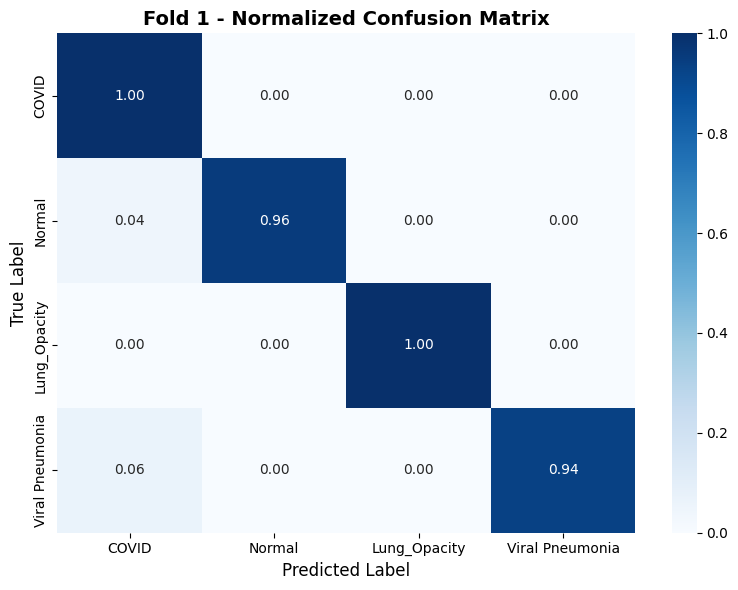

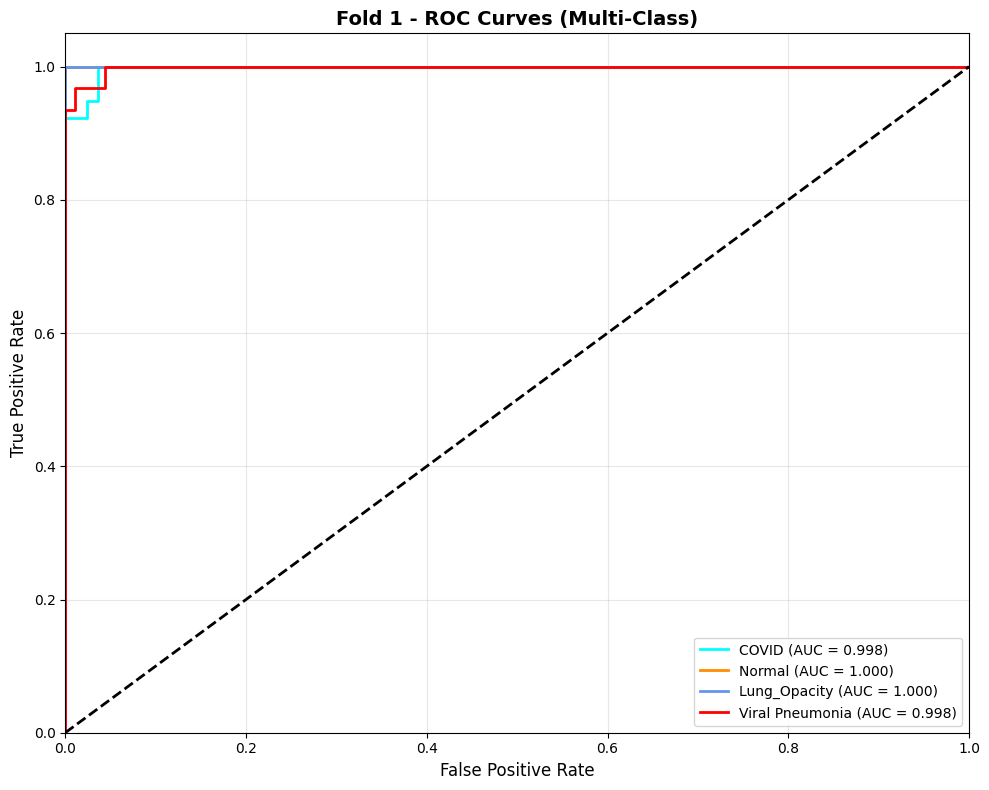

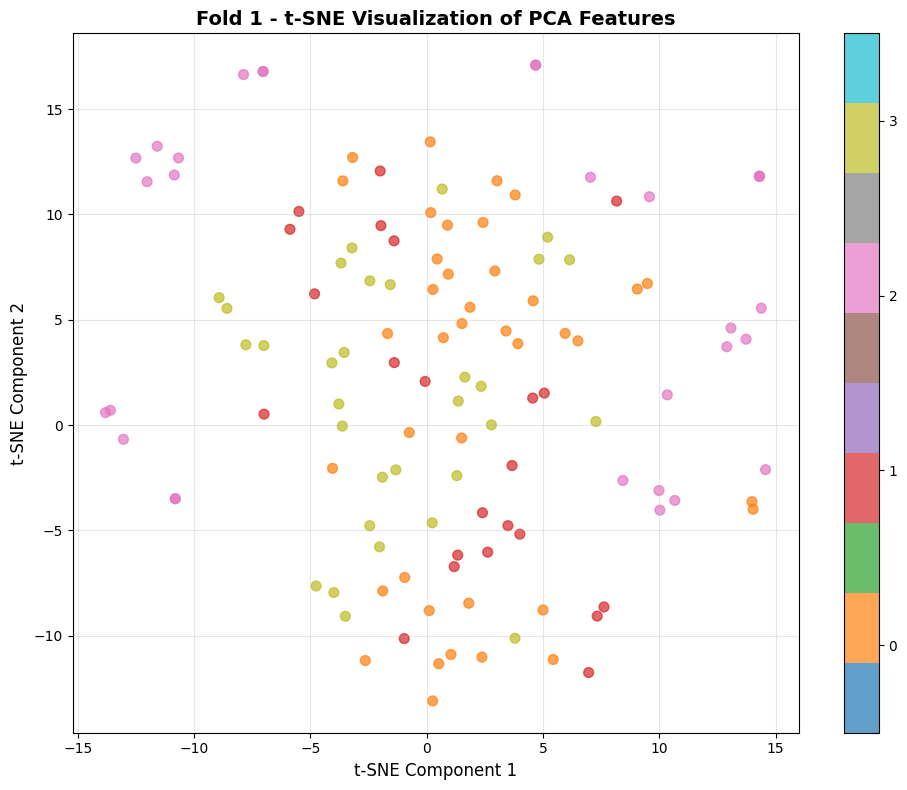


FOLD 2/5
Fold 2 Results:
  Accuracy:  0.9593
  Precision: 0.9603
  Recall:    0.9618
  F1-score:  0.9610


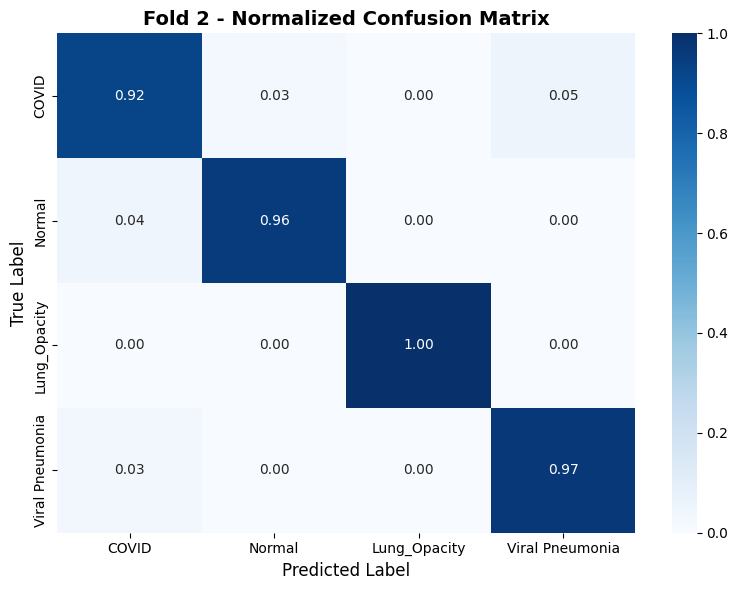

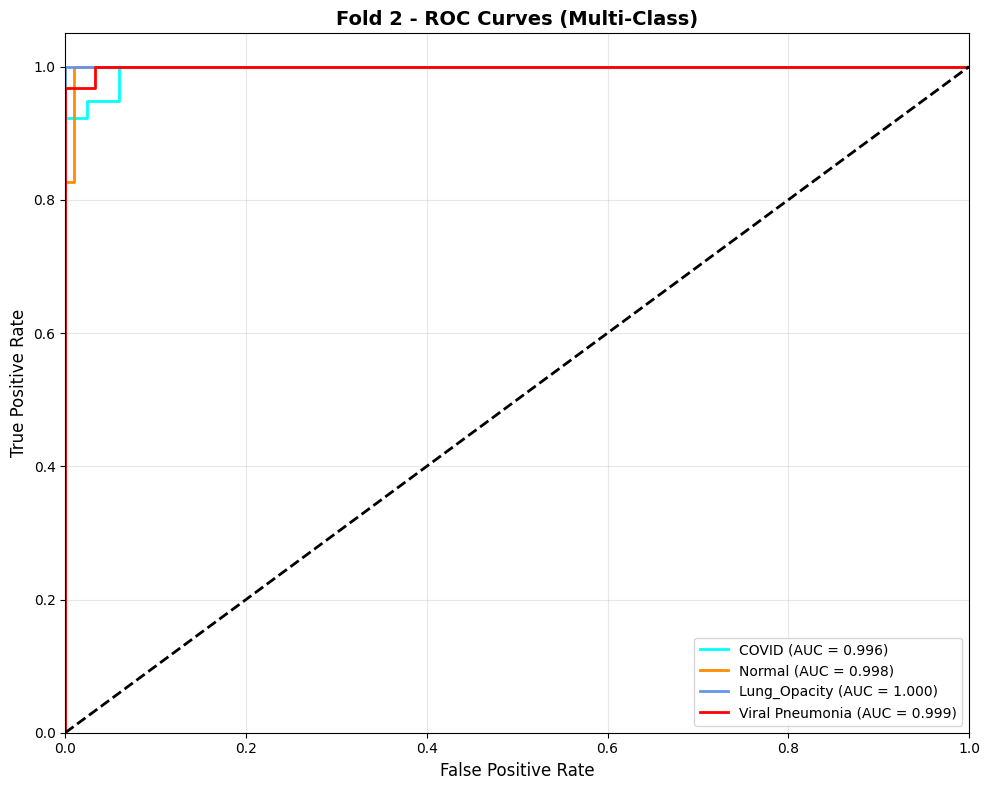

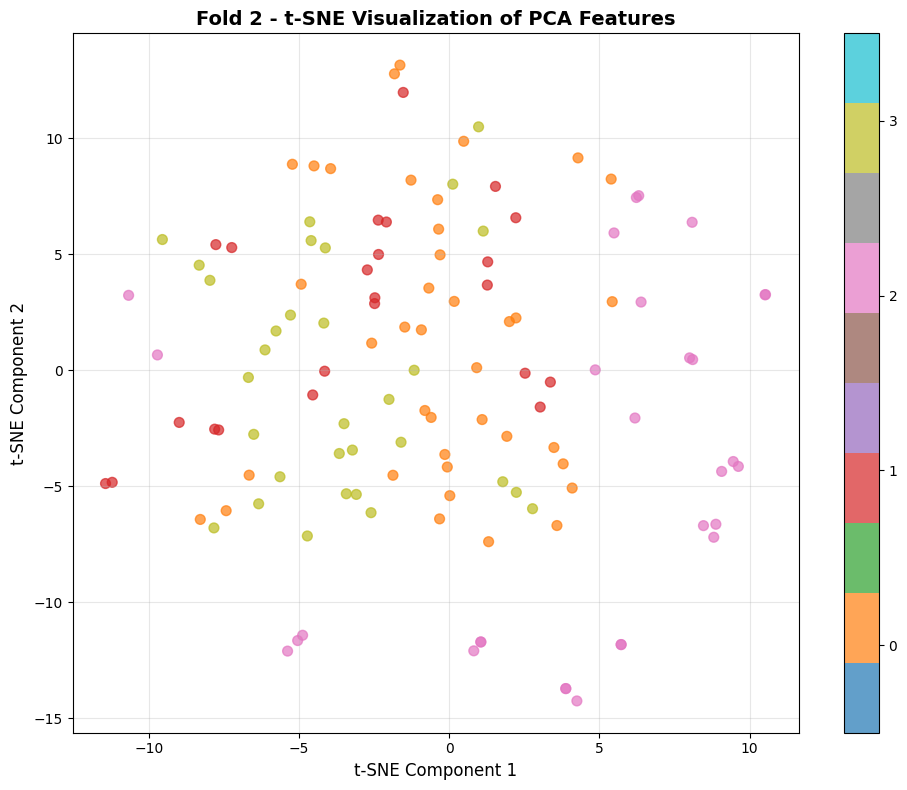


FOLD 3/5
Fold 3 Results:
  Accuracy:  0.9431
  Precision: 0.9433
  Recall:    0.9474
  F1-score:  0.9452


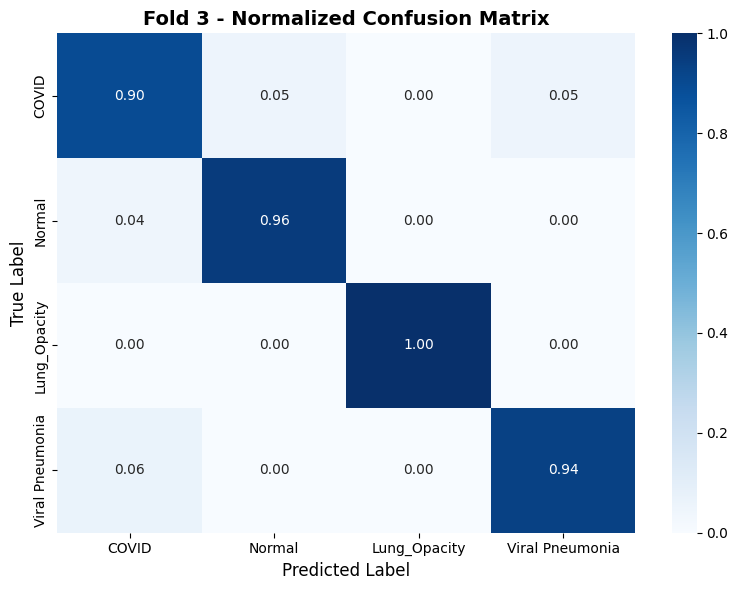

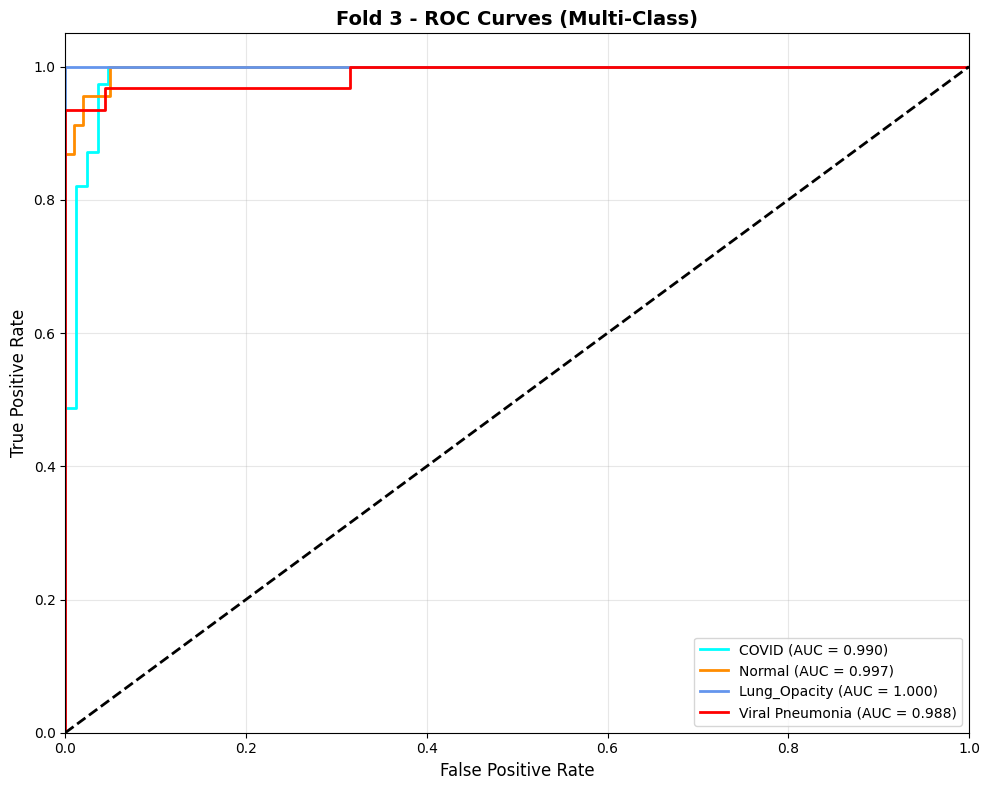

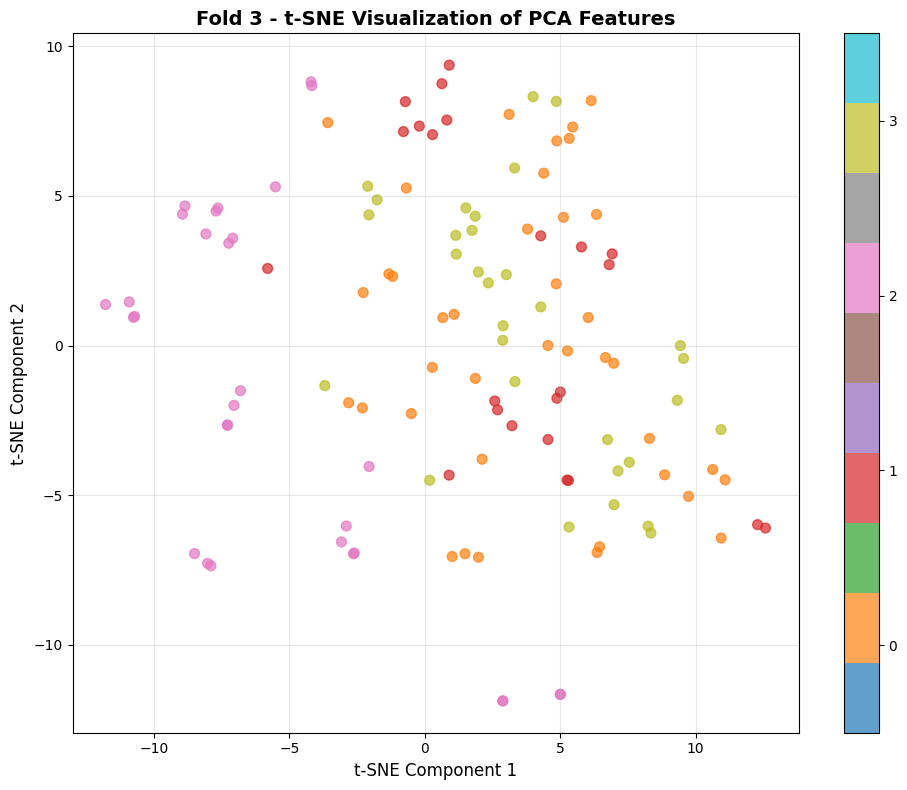


FOLD 4/5
Fold 4 Results:
  Accuracy:  0.9262
  Precision: 0.9356
  Recall:    0.9094
  F1-score:  0.9170


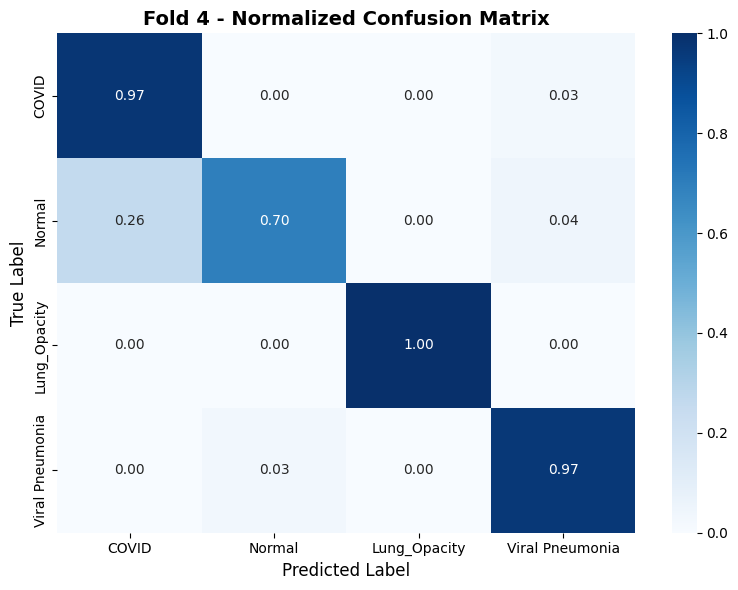

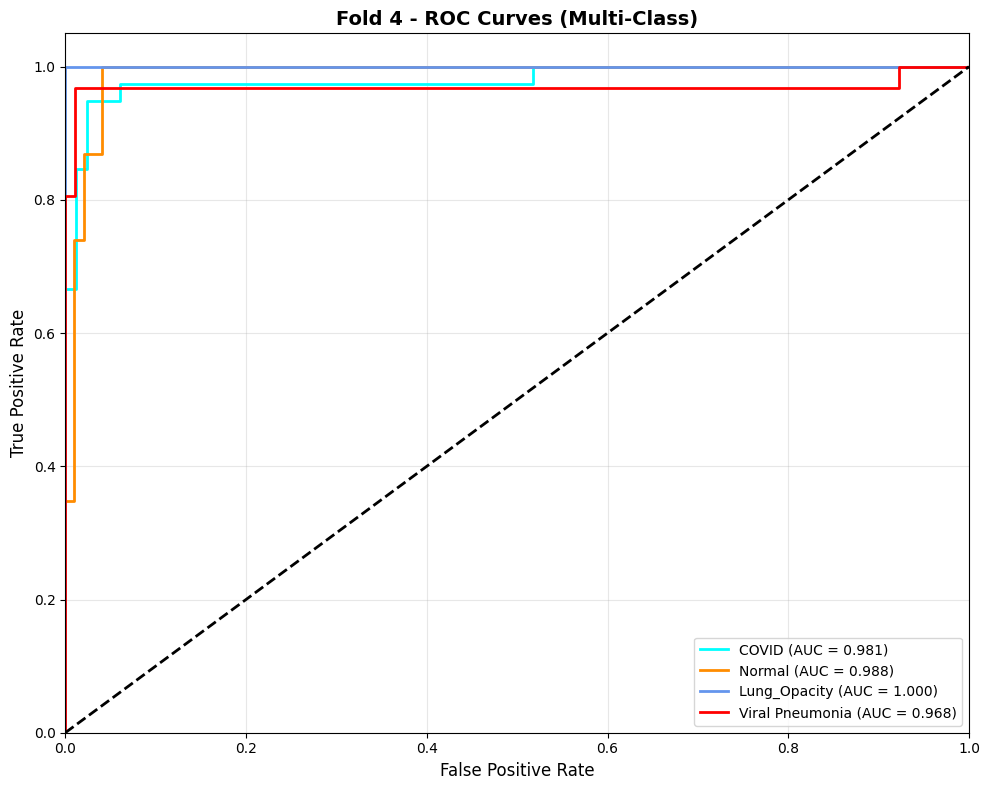

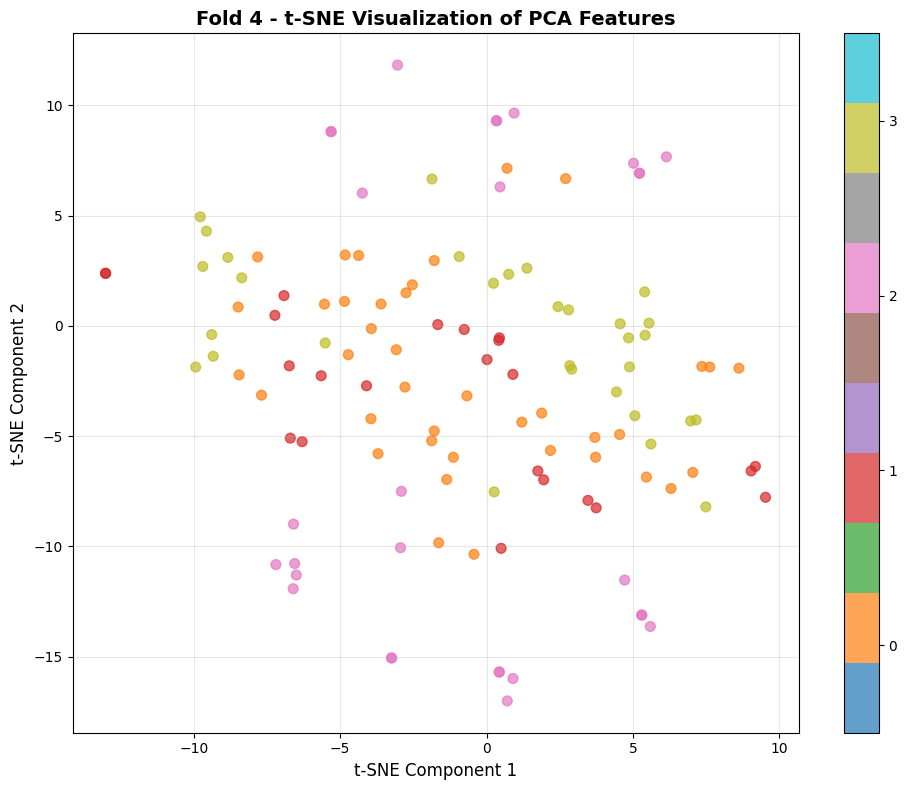


FOLD 5/5
Fold 5 Results:
  Accuracy:  0.9098
  Precision: 0.9171
  Recall:    0.9123
  F1-score:  0.9145


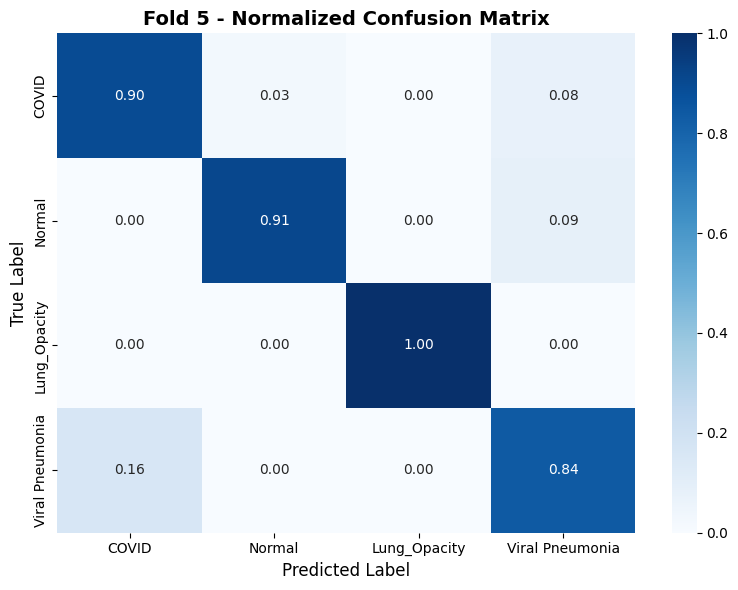

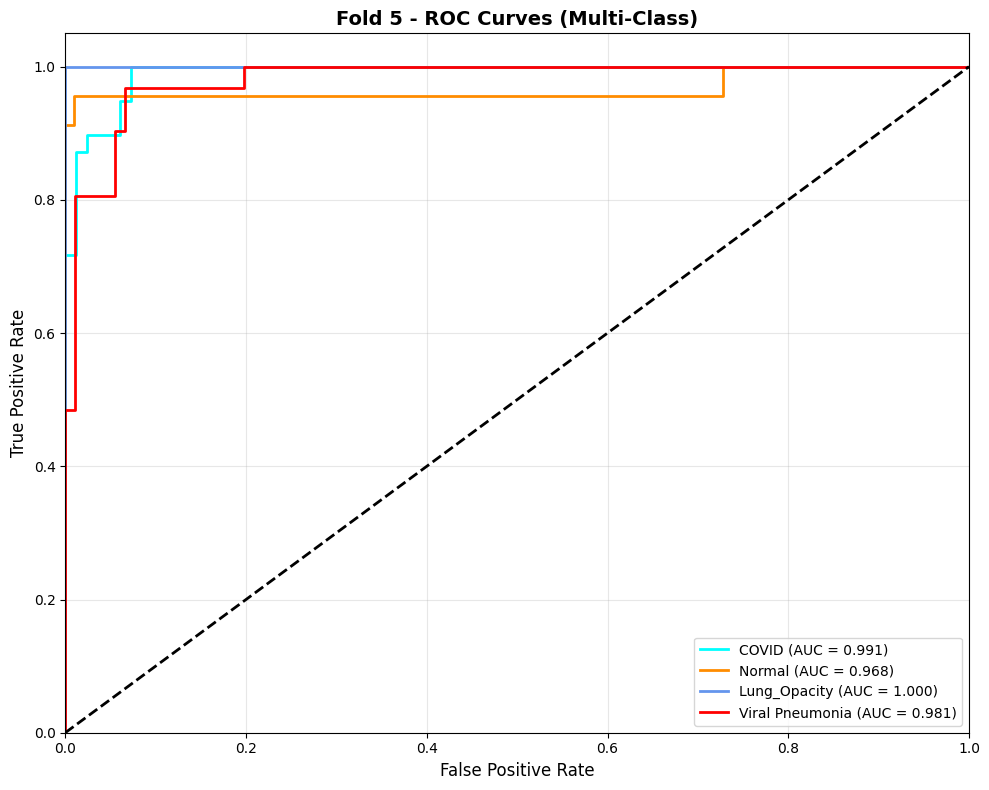

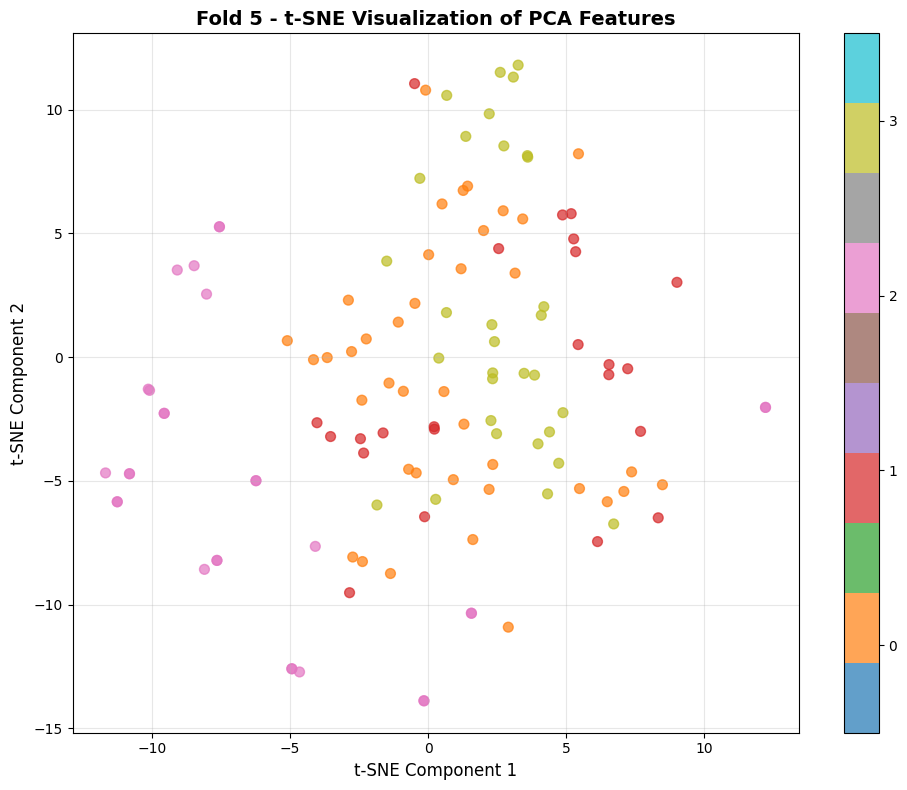


FINAL RESULTS (5-Fold Cross-Validation)
Accuracy : 0.9428 ± 0.0233
Precision: 0.9477 ± 0.0221
Recall   : 0.9408 ± 0.0258
F1-score : 0.9429 ± 0.0243
ROC-AUC  : 0.9935 ± 0.0055

STATISTICAL ANALYSIS

1. DESCRIPTIVE STATISTICS (5-Fold CV):
----------------------------------------
Accuracy    : 0.9428 ± 0.0233 [0.9098, 0.9756]
Precision   : 0.9477 ± 0.0221 [0.9171, 0.9821]
Recall      : 0.9408 ± 0.0258 [0.9094, 0.9730]
F1-score    : 0.9429 ± 0.0243 [0.9145, 0.9769]
ROC-AUC     : 0.9935 ± 0.0055 [0.9849, 0.9989]

2. ONE-SAMPLE T-TESTS (vs Random Guessing):
----------------------------------------
Accuracy    : t = 59.500, p = 0.000000 ***
Precision   : t = 63.022, p = 0.000000 ***
Recall      : t = 53.628, p = 0.000001 ***
F1-score    : t = 56.953, p = 0.000001 ***
ROC-AUC     : t = 181.074, p = 0.000000 ***

4. 95% CONFIDENCE INTERVALS:
----------------------------------------
Accuracy    : [0.9105, 0.9752]
Precision   : [0.9169, 0.9784]
Recall      : [0.9050, 0.9765]
F1-score    : [0.909

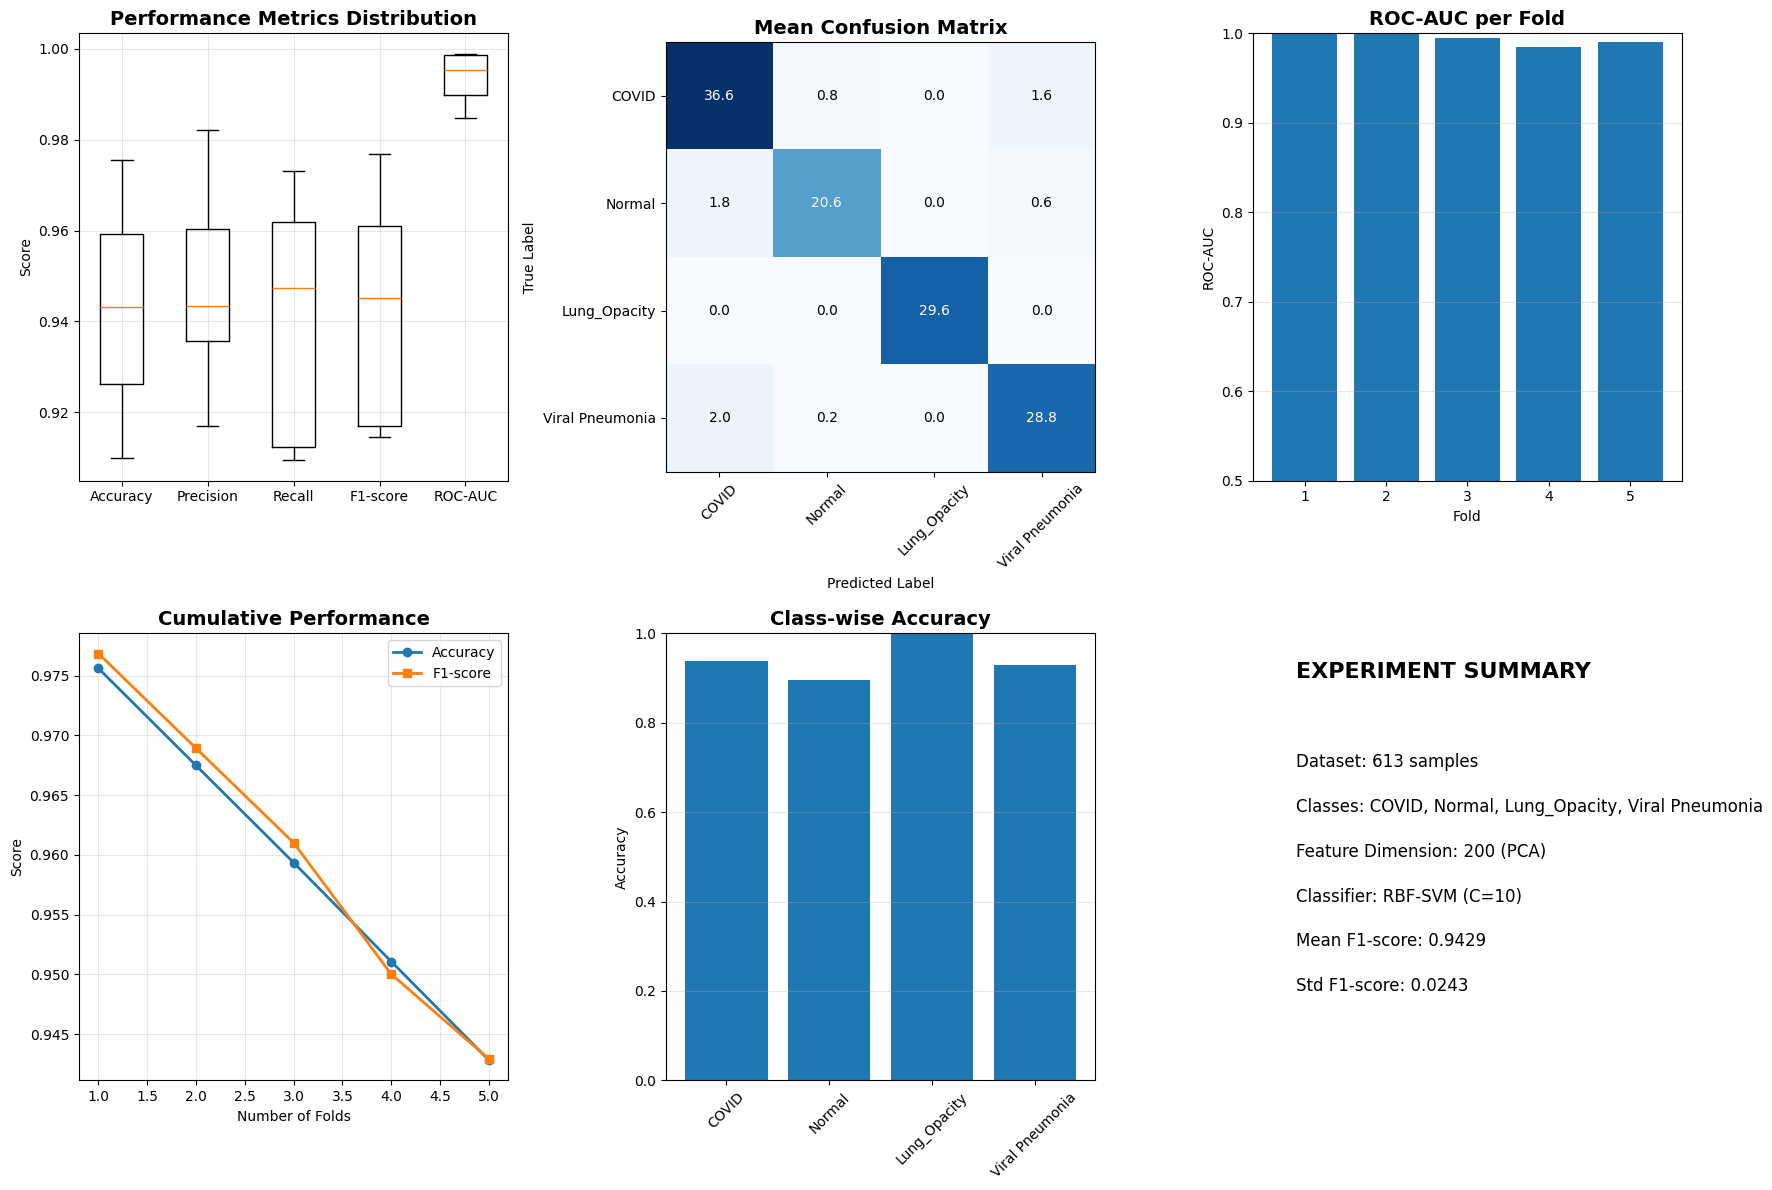


EXPERIMENT COMPLETED SUCCESSFULLY

To compare with baseline method:
1. Run your baseline model
2. Collect F1-scores from 5 folds
3. Call: perform_statistical_tests(results, baseline_results)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from scipy import stats
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ============================
# 1. Configuration
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For multi-class ROC
n_classes = 4  # Update based on your dataset
class_names = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']  # Update based on your dataset

# ============================
# 2. Data Loading & Transforms
# ============================
tfm_feat = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

data_dir = "/content/Data"
base_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=tfm_feat)

# Get labels and class distribution
all_labels = np.array([y for _, y in base_dataset.samples])
print("\n" + "="*50)
print("DATASET INFO:")
print("="*50)
print(f"Classes: {base_dataset.classes}")
print(f"Total samples: {len(base_dataset)}")
print(f"Class distribution: {Counter(all_labels)}")
print()

# ============================
# 3. Model Setup (Frozen Feature Extractors)
# ============================
def setup_models():
    """Initialize and freeze pretrained models"""
    resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)
    efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)

    # Remove classifiers
    resnet18.fc = nn.Identity()
    efficientnet.classifier[1] = nn.Identity()

    # Freeze weights
    resnet18.eval()
    efficientnet.eval()
    for p in resnet18.parameters(): p.requires_grad = False
    for p in efficientnet.parameters(): p.requires_grad = False

    return resnet18, efficientnet

resnet18, efficientnet = setup_models()

# ============================
# 4. Feature Extraction Function
# ============================
@torch.no_grad()
def extract_features_from_subset(subset):
    """Extract features from both CNNs for a given subset"""
    loader = DataLoader(subset, batch_size=16, shuffle=False)
    feats_list, labels_list = [], []

    for x, y in loader:
        x = x.to(device)
        feats_res = resnet18(x)
        feats_eff = efficientnet(x)
        feats = torch.cat([feats_res, feats_eff], dim=1)
        feats_list.append(feats.cpu().numpy())
        labels_list.append(y.numpy())

    return np.concatenate(feats_list), np.concatenate(labels_list)

# ============================
# 5. Visualization Functions
# ============================
def plot_confusion_matrix(cm, classes, fold, normalize=False):
    """Plot confusion matrix for a specific fold"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = f'Fold {fold} - Normalized Confusion Matrix'
    else:
        title = f'Fold {fold} - Confusion Matrix'

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true_bin, y_score, fold, class_names):
    """Plot ROC curves for multi-class classification"""
    plt.figure(figsize=(10, 8))

    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'Fold {fold} - ROC Curves (Multi-Class)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return roc_auc

def plot_feature_visualization(X_pca, y_true, fold, method='t-SNE'):
    """Visualize features using t-SNE or UMAP"""
    try:
        if method == 't-SNE':
            from sklearn.manifold import TSNE
            reducer = TSNE(n_components=2, random_state=42, perplexity=30)
            title = f'Fold {fold} - t-SNE Visualization of PCA Features'
        else:
            import umap
            reducer = umap.UMAP(random_state=42)
            title = f'Fold {fold} - UMAP Visualization of PCA Features'

        X_embedded = reducer.fit_transform(X_pca)

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
                             c=y_true, cmap='tab10', s=50, alpha=0.7)
        plt.colorbar(scatter, ticks=range(n_classes))
        plt.clim(-0.5, n_classes-0.5)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel(f'{method} Component 1', fontsize=12)
        plt.ylabel(f'{method} Component 2', fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    except ImportError as e:
        print(f"{method} not available: {e}")
        print("Install with: pip install scikit-learn umap-learn")

# ============================
# 6. Main Cross-Validation Pipeline
# ============================
def run_cross_validation():
    """Main CV pipeline with enhanced visualizations"""
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Storage for results
    accs, precs, recalls, f1s = [], [], [], []
    all_y_true, all_y_pred, all_y_score = [], [], []
    confusion_matrices = []
    roc_auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(all_labels)), all_labels), 1):
        print(f"\n{'='*60}")
        print(f"FOLD {fold}/5")
        print('='*60)

        # Create subsets
        train_subset = Subset(base_dataset, train_idx)
        val_subset = Subset(base_dataset, val_idx)

        # Extract features
        X_tr, y_tr = extract_features_from_subset(train_subset)
        X_val, y_val = extract_features_from_subset(val_subset)

        # Standardize + PCA
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        pca = PCA(n_components=200)
        X_tr_p = pca.fit_transform(X_tr_s)
        X_val_p = pca.transform(X_val_s)

        # Train SVM
        svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
        svm.fit(X_tr_p, y_tr)

        # Predictions
        y_pred = svm.predict(X_val_p)
        y_score = svm.predict_proba(X_val_p)

        # Store for statistical tests
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_score.append(y_score)

        # Calculate metrics
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)

        accs.append(acc)
        precs.append(prec)
        recalls.append(rec)
        f1s.append(f1)

        print(f"Fold {fold} Results:")
        print(f"  Accuracy:  {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall:    {rec:.4f}")
        print(f"  F1-score:  {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)
        plot_confusion_matrix(cm, class_names, fold, normalize=True)

        # ROC Curves
        y_val_bin = label_binarize(y_val, classes=range(n_classes))
        roc_auc = plot_roc_curves(y_val_bin, y_score, fold, class_names)
        roc_auc_scores.append(roc_auc['micro'])

        # Feature Visualization
        plot_feature_visualization(X_val_p, y_val, fold, method='t-SNE')

    return {
        'accs': accs, 'precs': precs, 'recalls': recalls, 'f1s': f1s,
        'all_y_true': all_y_true, 'all_y_pred': all_y_pred,
        'confusion_matrices': confusion_matrices,
        'roc_auc_scores': roc_auc_scores
    }

# ============================
# 7. Statistical Analysis Functions
# ============================
def perform_statistical_tests(results, baseline_results=None):
    """Perform statistical significance tests"""
    print("\n" + "="*60)
    print("STATISTICAL ANALYSIS")
    print("="*60)

    # 1. Descriptive Statistics
    print("\n1. DESCRIPTIVE STATISTICS (5-Fold CV):")
    print("-"*40)
    metrics = {
        'Accuracy': results['accs'],
        'Precision': results['precs'],
        'Recall': results['recalls'],
        'F1-score': results['f1s'],
        'ROC-AUC': results['roc_auc_scores']
    }

    for name, values in metrics.items():
        print(f"{name:12s}: {np.mean(values):.4f} ± {np.std(values):.4f} "
              f"[{np.min(values):.4f}, {np.max(values):.4f}]")

    # 2. One-sample t-test against random guessing
    print("\n2. ONE-SAMPLE T-TESTS (vs Random Guessing):")
    print("-"*40)
    random_guess = 1/n_classes  # For multi-class classification

    for name, values in metrics.items():
        if name == 'ROC-AUC':
            random_guess = 0.5  # AUC random performance
        t_stat, p_value = stats.ttest_1samp(values, random_guess)
        print(f"{name:12s}: t = {t_stat:.3f}, p = {p_value:.6f} "
              f"{'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''}")

    # 3. Paired t-test if baseline provided
    if baseline_results:
        print("\n3. PAIRED T-TESTS (vs Baseline):")
        print("-"*40)
        baseline_f1 = baseline_results['f1s']
        current_f1 = results['f1s']

        t_stat, p_value = stats.ttest_rel(current_f1, baseline_f1)
        print(f"F1-score comparison:")
        print(f"  Our Method: {np.mean(current_f1):.4f} ± {np.std(current_f1):.4f}")
        print(f"  Baseline:   {np.mean(baseline_f1):.4f} ± {np.std(baseline_f1):.4f}")
        print(f"  t-statistic: {t_stat:.3f}")
        print(f"  p-value:     {p_value:.6f}")

        if p_value < 0.05:
            print(f"  CONCLUSION: Statistically significant improvement (p < 0.05)")
        else:
            print(f"  CONCLUSION: No statistically significant difference")

    # 4. Confidence Intervals
    print("\n4. 95% CONFIDENCE INTERVALS:")
    print("-"*40)
    for name, values in metrics.items():
        ci_low, ci_high = stats.t.interval(0.95, len(values)-1,
                                          loc=np.mean(values),
                                          scale=stats.sem(values))
        print(f"{name:12s}: [{ci_low:.4f}, {ci_high:.4f}]")

# ============================
# 8. Summary Visualization
# ============================
def plot_summary_results(results):
    """Create summary plots of all folds"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    # 1. Box plot of metrics
    metrics_data = [results['accs'], results['precs'],
                    results['recalls'], results['f1s'], results['roc_auc_scores']]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']

    axes[0].boxplot(metrics_data, labels=metric_names)
    axes[0].set_title('Performance Metrics Distribution', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Score')
    axes[0].grid(alpha=0.3)

    # 2. Mean confusion matrix across folds
    mean_cm = np.mean(results['confusion_matrices'], axis=0)
    axes[1].imshow(mean_cm, interpolation='nearest', cmap='Blues')
    axes[1].set_title('Mean Confusion Matrix', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(n_classes))
    axes[1].set_yticks(range(n_classes))
    axes[1].set_xticklabels(class_names, rotation=45)
    axes[1].set_yticklabels(class_names)
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')

    # Add text annotations
    for i in range(n_classes):
        for j in range(n_classes):
            axes[1].text(j, i, f'{mean_cm[i, j]:.1f}',
                        ha="center", va="center",
                        color="white" if mean_cm[i, j] > mean_cm.max()/2 else "black")

    # 3. ROC-AUC per fold
    axes[2].bar(range(1, 6), results['roc_auc_scores'])
    axes[2].set_title('ROC-AUC per Fold', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Fold')
    axes[2].set_ylabel('ROC-AUC')
    axes[2].set_ylim([0.5, 1.0])
    axes[2].grid(alpha=0.3, axis='y')

    # 4. Learning curve (cumulative performance)
    cumulative_acc = np.cumsum(results['accs']) / np.arange(1, 6)
    cumulative_f1 = np.cumsum(results['f1s']) / np.arange(1, 6)

    axes[3].plot(range(1, 6), cumulative_acc, 'o-', label='Accuracy', linewidth=2)
    axes[3].plot(range(1, 6), cumulative_f1, 's-', label='F1-score', linewidth=2)
    axes[3].set_title('Cumulative Performance', fontsize=14, fontweight='bold')
    axes[3].set_xlabel('Number of Folds')
    axes[3].set_ylabel('Score')
    axes[3].legend()
    axes[3].grid(alpha=0.3)

    # 5. Class-wise performance
    class_metrics = []
    for cls in range(n_classes):
        # Calculate class-specific metrics (simplified)
        cls_acc = []
        for cm in results['confusion_matrices']:
            if cm[cls, :].sum() > 0:
                cls_acc.append(cm[cls, cls] / cm[cls, :].sum())
            else:
                cls_acc.append(0)
        class_metrics.append(np.mean(cls_acc))

    axes[4].bar(class_names, class_metrics)
    axes[4].set_title('Class-wise Accuracy', fontsize=14, fontweight='bold')
    axes[4].set_ylabel('Accuracy')
    axes[4].set_ylim([0, 1])
    axes[4].tick_params(axis='x', rotation=45)
    axes[4].grid(alpha=0.3, axis='y')

    # 6. PCA variance explained
    axes[5].axis('off')
    axes[5].text(0.1, 0.9, 'EXPERIMENT SUMMARY', fontsize=16, fontweight='bold')
    axes[5].text(0.1, 0.7, f'Dataset: {len(base_dataset)} samples', fontsize=12)
    axes[5].text(0.1, 0.6, f'Classes: {", ".join(class_names)}', fontsize=12)
    axes[5].text(0.1, 0.5, f'Feature Dimension: 200 (PCA)', fontsize=12)
    axes[5].text(0.1, 0.4, f'Classifier: RBF-SVM (C=10)', fontsize=12)
    axes[5].text(0.1, 0.3, f'Mean F1-score: {np.mean(results["f1s"]):.4f}', fontsize=12)
    axes[5].text(0.1, 0.2, f'Std F1-score: {np.std(results["f1s"]):.4f}', fontsize=12)

    plt.tight_layout()
    plt.show()

# ============================
# 9. Main Execution
# ============================
if __name__ == "__main__":
    print("\n" + "="*60)
    print("DEEP FEATURE FUSION WITH FROZEN CNN + PCA + SVM")
    print("="*60)

    # Run cross-validation
    results = run_cross_validation()

    # Print final results
    print("\n" + "="*60)
    print("FINAL RESULTS (5-Fold Cross-Validation)")
    print("="*60)
    print(f"Accuracy : {np.mean(results['accs']):.4f} ± {np.std(results['accs']):.4f}")
    print(f"Precision: {np.mean(results['precs']):.4f} ± {np.std(results['precs']):.4f}")
    print(f"Recall   : {np.mean(results['recalls']):.4f} ± {np.std(results['recalls']):.4f}")
    print(f"F1-score : {np.mean(results['f1s']):.4f} ± {np.std(results['f1s']):.4f}")
    print(f"ROC-AUC  : {np.mean(results['roc_auc_scores']):.4f} ± {np.std(results['roc_auc_scores']):.4f}")

    # Statistical tests
    perform_statistical_tests(results)

    # Summary plots
    plot_summary_results(results)

    # Save results
    print("\n" + "="*60)
    print("EXPERIMENT COMPLETED SUCCESSFULLY")
    print("="*60)
    print("\nTo compare with baseline method:")
    print("1. Run your baseline model")
    print("2. Collect F1-scores from 5 folds")
    print("3. Call: perform_statistical_tests(results, baseline_results)")